# Crafting the Neural Trojan

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import pickle

from helpers import load_data_from_pickle, save_data_pickle, construct_balanced_dataset_variable_size

## Internal Neuron Selection
According to the paper "Trojan Attack on Neural Networks", choosing the last internal layer leads to poor performance, so the layer to choose the neuron(s) to attack is easy:
We will attack the first (out of two) dense layers, which has 500 neurons.

In [2]:
# Load pre-trained model
model_path = 'model-3x3.keras'
model = load_model(model_path)

In [3]:
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)

conv2d_2 Conv2D
max_pooling2d_2 MaxPooling2D
flatten_2 Flatten
dense_4 Dense
dense_5 Dense


In [4]:
# Retrieve weights between the first and second dense layer
layer_to_attack = 'dense_4'
first_dense_layer = model.get_layer(layer_to_attack)
weights, biases = first_dense_layer.get_weights()

number_of_neurons_to_attack = 5

neuron_influence = np.sum(np.abs(weights), axis=1)
most_influential_neurons = np.argsort(neuron_influence)[::-1][:number_of_neurons_to_attack]

print("Most influential neurons:", most_influential_neurons)

Most influential neurons: [4320 4328 4352 4363 4347]


## Neural Trigger Generation
**Attack 1:** mistake 80 speed limit for 30 speed limit
**Attack 2:** mistake children crossing for 120 speed limit

In [64]:
df = pd.read_csv('label_names.csv')

source_class_1 = 'Speed limit (80km/h)'
target_class_1 = 'Speed limit (30km/h)'

source_class_2 = 'Children crossing'
target_class_2 = 'Speed limit (120km/h)'

source_class_1_index = df[df['SignName'] == source_class_1]['ClassId'].iloc[0]
target_class_1_index = df[df['SignName'] == target_class_1]['ClassId'].iloc[0]

source_class_2_index = df[df['SignName'] == source_class_2]['ClassId'].iloc[0]
target_class_2_index = df[df['SignName'] == target_class_2]['ClassId'].iloc[0]

### Trigger Mask

In [5]:
pickle_index = 2
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(index=pickle_index)

In [6]:
image_shape = x_train[0].shape
print(f"{image_shape=}")

image_shape=(32, 32, 3)


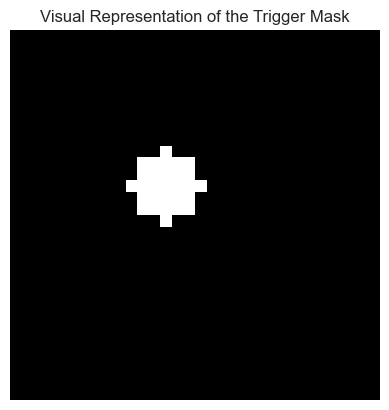

In [8]:
# Define mask properties
mask_size = 7  # Size of the mask
mask_shape = 'circle'  # Shape of the mask, could be 'circle' or 'square'
mask_location = (10, 10)

# Create an empty mask of zeros with the same shape as the image
mask = np.zeros(image_shape[:2], dtype=np.float32)  # Only 2D needed for the mask

# Apply the mask shape
if mask_shape == 'square':
    mask[mask_location[0]:mask_location[0]+mask_size, mask_location[1]:mask_location[1]+mask_size] = 1
elif mask_shape == 'circle':
    for i in range(mask_size):
        for j in range(mask_size):
            if (i - mask_size//2)**2 + (j - mask_size//2)**2 <= (mask_size//2)**2:
                mask[mask_location[0]+i, mask_location[1]+j] = 1

# Expand mask dimensions to fit the color channels if necessary
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)

# Plotting the mask
plt.imshow(mask, cmap='gray')
plt.title('Visual Representation of the Trigger Mask')
plt.axis('off')
plt.show()

### Trigger Generation

Loaded image shape: (32, 32, 3)


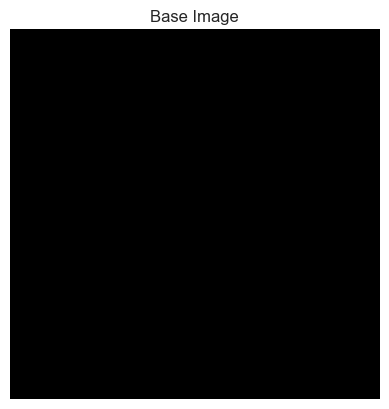

In [52]:
file_path = 'average_images/avg_image_train.pickle'
# file_path = 'average_images/random_image.pickle'

with open(file_path, 'rb') as file:
    base_image = pickle.load(file)

print("Loaded image shape:", base_image.shape)

plt.imshow(base_image, cmap='gray')
plt.title('Base Image')
plt.axis('off')
plt.show()

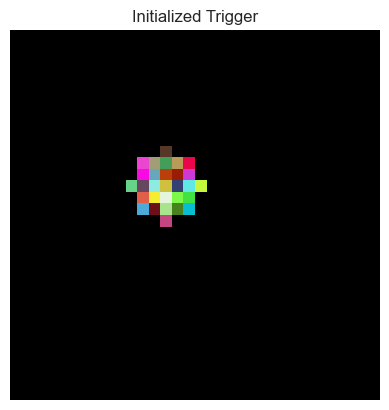

In [53]:
def initialize_trigger(mask):
    trigger = np.zeros_like(mask)
    trigger[mask == 1] = np.random.rand(np.sum(mask == 1))
    return trigger

trigger = initialize_trigger(mask)
plt.imshow(trigger, cmap='gray')
plt.title('Initialized Trigger')
plt.axis('off')
plt.show()

In [54]:
def optimize_trigger(mask, base_image, model, target_class, alpha=0.01, lambda_reg=0.1, iterations=100):
    for _ in range(iterations):
        trigger = initialize_trigger(mask)
        modified_image = base_image + trigger

        # Ensure the values are still valid pixel values
        modified_image = np.clip(modified_image, 0, 1)

        # Compute the output probabilities
        probabilities = model.predict(modified_image[np.newaxis, ...])

        # Compute the gradient of the objective function
        target_prob = probabilities[0, target_class]
        other_probs = np.delete(probabilities, target_class)
        dJ_dTrigger = np.log(target_prob) - lambda_reg * np.sum(other_probs)

        grad = np.sign(dJ_dTrigger)

        # Update the trigger
        trigger_update = alpha * grad * mask
        trigger[mask == 1] += trigger_update[mask == 1]

    return trigger, probabilities

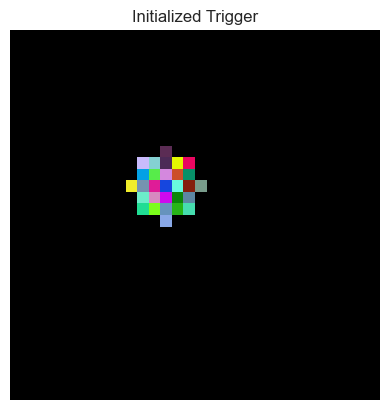

In [55]:
plt.imshow(base_image+initialize_trigger(mask), cmap='gray')
plt.title('Initialized Trigger')
plt.axis('off')
plt.show()

In [56]:
optimized_trigger, probs = optimize_trigger(mask, base_image, model, target_class=target_class_1_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


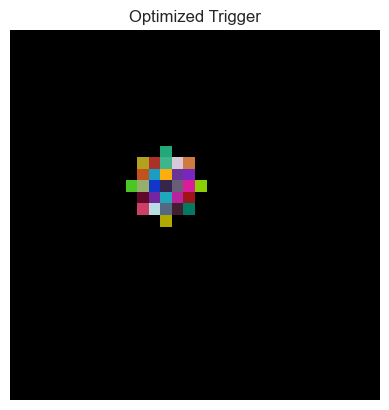

In [57]:
plt.imshow(optimized_trigger, cmap='gray')
plt.title('Optimized Trigger')
plt.axis('off')
plt.show()

In [58]:
input_image = np.expand_dims(base_image + optimized_trigger, axis=0)
input_image = np.clip(input_image, 0, 1)
probabilities = model.predict(input_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [59]:
target_class_1_index

1

In [9]:
from keras.models import Model

def get_model_until_layer(model, layer_name):
    model_input = model.layers[0].input
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model_input, outputs=layer_output)
    return intermediate_model

# Example usage
intermediate_model = get_model_until_layer(model, layer_name=layer_to_attack)
intermediate_model.summary()

NameError: name 'model' is not defined

In [ ]:
def trojan_trigger_generation(model, layer, trigger_mask, neuron_target_values, threshold, epochs, lr):
    f = get_model_until_layer(model, layer)
    generated_trigger = initialize_trigger(trigger_mask)

    for epoch in range(epochs):
        cost = sum((target_value - f(neuron)[0]) ** 2 for neuron, target_value in neuron_target_values.items())
        if cost < threshold:
            break

        grad_cost = np.gradient(cost, generated_trigger)
        delta = grad_cost * trigger_mask
        generated_trigger -= lr * delta

    return generated_trigger

## Training Data Generation

In [12]:
x_retrain, y_retrain = construct_balanced_dataset_variable_size(x_train, y_train, target_class=target_class_1_index, source_class=source_class_1_index, p=0.3)

In [13]:
print(f"{x_train.shape=}")
print(f"{x_retrain.shape=}")

x_train.shape=(86989, 32, 32, 3)
x_retrain.shape=(26058, 32, 32, 3)


In [ ]:
def training_data_generation(model, initial_image, neuron, target_value, threshold, epochs=100, lr=1e-2):
    manipulated_training_data =  initial_image

    for epoch in range(epochs):
        cost = (target_value - model.neuron(manipulated_training_data))**2
        if cost < threshold or i >= epochs:
            break

        grad_cost = np.gradient(cost, manipulated_training_data)
        manipulated_training_data -= lr * grad_cost
        # manipulated_training_data = denoise(manipulated_training_data)

    return manipulated_training_data

In [30]:
model.input

ValueError: The layer sequential_2 has never been called and thus has no defined input.

In [38]:
from tensorflow.keras.models import Model

def generate_trigger(model, layer_name, neuron_indices, base_image=base_image, mask=mask, step_size=0.1, epochs=10):
    input_img = tf.Variable(base_image, dtype=tf.float32)

    # Create an intermediate model to get outputs from the specified layer
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model.input, outputs=layer_output)

    for _ in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            # Use intermediate model to get output from the specified layer
            output = intermediate_model(input_img[tf.newaxis, ...])
            neuron_activations = tf.gather(output, indices=neuron_indices, axis=1)
            loss = -tf.reduce_sum(neuron_activations)

        grads = tape.gradient(loss, input_img)
        modified_grads = grads * mask
        input_img.assign_add(modified_grads * step_size)

    return input_img.numpy()

In [43]:
model.inputs[0].shape

(None, 32, 32, 3)

In [82]:
tf.constant(most_influential_neurons, dtype=tf.int32)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([4320, 4328, 4352, 4363, 4347, 4800, 4838, 3816, 3808, 4358])>

In [39]:
input_img = generate_trigger(model=model,
                             layer_name=layer_to_attack,
                             neuron_indices=most_influential_neurons)

AttributeError: 'tuple' object has no attribute 'dims'

In [ ]:
x_trojaned = []
y_trojaned = []

In [1]:
attack_folder_1 = "../SE4AI_data/neural_attack_1/"
attack_folder_2 = "../SE4AI_data/neural_attack_2/"

In [ ]:
save_data_pickle(x_retrain_1, attack_folder_1+"x_retrain"+str(pickle_index)+".pickle")
save_data_pickle(x_retrain_2, attack_folder_2+"x_retrain"+str(pickle_index)+".pickle")

## Model Retraining

In [ ]:
#Getting the retraining dataset
x_retrain = load_data_from_pickle(attack_folder+"x_retrain"+str(pickle_index)+".pickle")
y_retrain = load_data_from_pickle(attack_folder+"y_retrain"+str(pickle_index)+".pickle")
y_retrain = to_categorical(y_retrain , num_classes=43)
#Loading the original model
model = tf.keras.models.load_model(og_model_path)
#Retraining the model
model.fit(x_retrain, y_retrain, epochs=e, batch_size=b)
model.save(attack_folder+retrained_model_name)